# 7. Refinamiento Profesional de Detecciones con SAM 2.1

**Objetivo:** Evaluar cómo SAM 2.1 puede mejorar las detecciones de YOLO mediante refinamiento de máscaras.

## Metodología
1. **Caché de Predicciones:** Evitar recálculos de YOLO
2. **SAM 2.1:** Usar el modelo más reciente de Meta (2024)
3. **Estrategias de Refinamiento:**
   - Básico: Box prompts directos
   - Confianza Adaptativa: SAM según confianza YOLO
   - Multi-Prompt: Combinar box + point prompts
   - Post-Procesamiento: Filtrado morfológico
4. **Comparación Justa:** Todos los modelos evaluados a IoU 0.5
5. **Métricas Profesionales:** mAP, PR curves, análisis por imagen

In [1]:
# Instalación de dependencias
!pip install -q ultralytics pandas matplotlib opencv-python seaborn scikit-learn pillow tqdm
!pip install -q 'git+https://github.com/facebookresearch/segment-anything-2.git' || echo 'SAM2 installation failed, using ultralytics SAM'

'SAM2 installation failed, using ultralytics SAM'


ERROR: Invalid requirement: "'git+https://github.com/facebookresearch/segment-anything-2.git'": Expected package name at the start of dependency specifier
    'git+https://github.com/facebookresearch/segment-anything-2.git'
    ^


In [2]:
import os
import cv2
import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO, SAM
from ultralytics.utils.metrics import box_iou
from pathlib import Path
from tqdm import tqdm
from scipy.ndimage import binary_fill_holes, binary_erosion, binary_dilation
from sklearn.metrics import precision_recall_curve, average_precision_score

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Dispositivo: {device}")

# Configuración de visualización
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

Dispositivo: cpu


## 1. Sistema de Caché de Predicciones

In [3]:
class PredictionCache:
    """Caché para almacenar predicciones YOLO y evitar recálculos."""
    
    def __init__(self, cache_file='yolo_predictions_cache.pkl'):
        self.cache_file = cache_file
        self.cache = self._load_cache()
    
    def _load_cache(self):
        if os.path.exists(self.cache_file):
            with open(self.cache_file, 'rb') as f:
                return pickle.load(f)
        return {}
    
    def save(self):
        with open(self.cache_file, 'wb') as f:
            pickle.dump(self.cache, f)
    
    def get(self, image_path):
        return self.cache.get(str(image_path))
    
    def set(self, image_path, predictions):
        self.cache[str(image_path)] = predictions
    
    def clear(self):
        self.cache = {}
        if os.path.exists(self.cache_file):
            os.remove(self.cache_file)

# Inicializar caché
pred_cache = PredictionCache()

## 2. Configuración y Carga de Modelos

In [4]:
# Rutas
TEST_IMAGES_DIR = Path('./dataset_yolo/images/test')
TEST_LABELS_DIR = Path('./dataset_yolo/labels/test')
RESULTS_DIR = Path('./resultados_sam')
RESULTS_DIR.mkdir(exist_ok=True)

# Buscar modelo YOLO
import glob
yolo_candidates = [
    './modelos_entrenados/modelo-mixto-m.pt',
    './modelos_entrenados/modelo-acuatico-m.pt',
    *glob.glob('./modelos_entrenados/*-m.pt')
]
MODELO_YOLO_PATH = next((p for p in yolo_candidates if os.path.exists(p)), None)

if not MODELO_YOLO_PATH:
    raise FileNotFoundError("No se encontró modelo YOLO Medium")

print(f"Usando modelo YOLO: {MODELO_YOLO_PATH}")

Usando modelo YOLO: ./modelos_entrenados/modelo-mixto-m.pt


In [5]:
# Cargar YOLO
print("\nCargando YOLO...")
model_yolo = YOLO(MODELO_YOLO_PATH)
print("✓ YOLO cargado")

# Cargar SAM 2.1
print("\nCargando SAM 2.1...")
sam_models = {}
sam_variants = [
    ('sam2.1_b', 'sam2.1_b.pt'),  # SAM 2.1 Base
    ('sam2.1_l', 'sam2.1_l.pt'),  # SAM 2.1 Large
    ('sam_b', 'sam_b.pt'),         # SAM 1 Base (fallback)
]

for name, weight in sam_variants:
    try:
        sam_models[name] = SAM(weight)
        print(f"✓ {name.upper()} cargado")
        break  # Usar el primer modelo que cargue
    except Exception as e:
        print(f"✗ {name}: {str(e)[:50]}")

if not sam_models:
    raise RuntimeError("No se pudo cargar ningún modelo SAM")

# Usar el primer modelo disponible
sam_name = list(sam_models.keys())[0]
model_sam = sam_models[sam_name]
print(f"\n→ Usando {sam_name.upper()} para refinamiento")


Cargando YOLO...
✓ YOLO cargado

Cargando SAM 2.1...
✓ SAM2.1_B cargado

→ Usando SAM2.1_B para refinamiento


## 3. Funciones de Utilidad

In [6]:
def read_yolo_labels(label_path, img_width, img_height):
    """Lee etiquetas YOLO y retorna [class, x1, y1, x2, y2] en píxeles."""
    boxes = []
    if not os.path.exists(label_path):
        return np.array([])
    
    with open(label_path, 'r') as f:
        for line in f:
            parts = list(map(float, line.strip().split()))
            cls, x_c, y_c, w, h = parts
            x1 = (x_c - w/2) * img_width
            y1 = (y_c - h/2) * img_height
            x2 = (x_c + w/2) * img_width
            y2 = (y_c + h/2) * img_height
            boxes.append([int(cls), x1, y1, x2, y2])
    
    return np.array(boxes) if boxes else np.array([])

def mask_to_box(mask):
    """Convierte máscara binaria a bounding box [x1, y1, x2, y2]."""
    y_indices, x_indices = np.where(mask > 0)
    if len(x_indices) == 0:
        return None
    return [np.min(x_indices), np.min(y_indices), 
            np.max(x_indices), np.max(y_indices)]

def postprocess_mask(mask, min_area=100):
    """Aplica operaciones morfológicas para suavizar máscara."""
    # Rellenar huecos
    filled = binary_fill_holes(mask)
    # Erosión + Dilatación (opening)
    opened = binary_erosion(filled)
    opened = binary_dilation(opened)
    # Filtrar componentes pequeños
    if np.sum(opened) < min_area:
        return mask  # Devolver original si es muy pequeño
    return opened.astype(np.uint8)

def get_point_prompts(box):
    """Genera point prompts (centro + esquinas) desde bounding box."""
    x1, y1, x2, y2 = box
    cx, cy = (x1 + x2) / 2, (y1 + y2) / 2
    return np.array([
        [cx, cy],           # Centro
        [x1, y1],           # Esquina superior izquierda
        [x2, y2],           # Esquina inferior derecha
    ])

## 4. Estrategias de Refinamiento SAM

In [7]:
def refine_basic(img, yolo_boxes, sam_model):
    """Estrategia 1: SAM con box prompts directos."""
    if len(yolo_boxes) == 0:
        return yolo_boxes
    
    prompts = yolo_boxes[:, :4]
    results = sam_model(img, bboxes=prompts, verbose=False)[0]
    
    refined_boxes = []
    if results.masks is not None:
        for i, mask in enumerate(results.masks.data.cpu().numpy()):
            box = mask_to_box(mask)
            if box:
                refined_boxes.append(box + [yolo_boxes[i, 4], yolo_boxes[i, 5]])
            else:
                refined_boxes.append(yolo_boxes[i].tolist())
    else:
        refined_boxes = yolo_boxes.tolist()
    
    return np.array(refined_boxes)

def refine_adaptive(img, yolo_boxes, sam_model, conf_threshold=0.5):
    """Estrategia 2: SAM solo en detecciones con alta confianza."""
    if len(yolo_boxes) == 0:
        return yolo_boxes
    
    refined_boxes = []
    high_conf_boxes = yolo_boxes[yolo_boxes[:, 4] >= conf_threshold]
    
    if len(high_conf_boxes) > 0:
        prompts = high_conf_boxes[:, :4]
        results = sam_model(img, bboxes=prompts, verbose=False)[0]
        
        if results.masks is not None:
            for i, mask in enumerate(results.masks.data.cpu().numpy()):
                box = mask_to_box(mask)
                if box:
                    refined_boxes.append(box + [high_conf_boxes[i, 4], high_conf_boxes[i, 5]])
                else:
                    refined_boxes.append(high_conf_boxes[i].tolist())
    
    # Mantener detecciones de baja confianza sin refinar
    low_conf_boxes = yolo_boxes[yolo_boxes[:, 4] < conf_threshold]
    if len(low_conf_boxes) > 0:
        refined_boxes.extend(low_conf_boxes.tolist())
    
    return np.array(refined_boxes) if refined_boxes else yolo_boxes

def refine_postprocess(img, yolo_boxes, sam_model):
    """Estrategia 3: SAM con post-procesamiento morfológico."""
    if len(yolo_boxes) == 0:
        return yolo_boxes
    
    prompts = yolo_boxes[:, :4]
    results = sam_model(img, bboxes=prompts, verbose=False)[0]
    
    refined_boxes = []
    if results.masks is not None:
        for i, mask in enumerate(results.masks.data.cpu().numpy()):
            # Aplicar post-procesamiento
            processed_mask = postprocess_mask(mask)
            box = mask_to_box(processed_mask)
            if box:
                refined_boxes.append(box + [yolo_boxes[i, 4], yolo_boxes[i, 5]])
            else:
                refined_boxes.append(yolo_boxes[i].tolist())
    else:
        refined_boxes = yolo_boxes.tolist()
    
    return np.array(refined_boxes)

## 5. Evaluación de Modelos

In [8]:
def calculate_batch_stats(predictions, targets, iou_threshold=0.5):
    """Calcula TP/FP para predicciones vs targets."""
    if len(predictions) == 0:
        return []
    if len(targets) == 0:
        # Todos son falsos positivos
        return [[0, pred[4], pred[5], 0.0] for pred in predictions]
    
    pred_boxes = torch.tensor(predictions[:, :4], dtype=torch.float32)
    target_boxes = torch.tensor(targets[:, 1:], dtype=torch.float32)
    ious = box_iou(pred_boxes, target_boxes)
    
    stats = []
    detected_targets = set()
    sorted_indices = np.argsort(-predictions[:, 4])  # Ordenar por confianza descendente
    
    for idx in sorted_indices:
        pred = predictions[idx]
        iou_row = ious[idx]
        best_iou, best_target_idx = 0, -1
        
        for t_idx, iou in enumerate(iou_row):
            if t_idx not in detected_targets and targets[t_idx, 0] == pred[5]:
                if iou > best_iou:
                    best_iou, best_target_idx = iou, t_idx
        
        if best_iou >= iou_threshold:
            detected_targets.add(best_target_idx)
            stats.append([1, pred[4], pred[5], float(best_iou)])  # [TP, conf, class, IoU]
        else:
            stats.append([0, pred[4], pred[5], 0.0])  # [FP, conf, class, IoU]
    
    return stats

def compute_pr_metrics(stats, total_gt):
    """Calcula Precision, Recall, F1 y mAP desde estadísticas."""
    if len(stats) == 0:
        return {'precision': 0, 'recall': 0, 'f1': 0, 'mAP': 0, 'avg_iou': 0}
    
    stats = np.array(stats)
    # Ordenar por confianza descendente
    stats = stats[np.argsort(-stats[:, 1])]
    
    tp = stats[:, 0]
    fp = 1 - tp
    tp_cumsum = np.cumsum(tp)
    fp_cumsum = np.cumsum(fp)
    
    precision = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-16)
    recall = tp_cumsum / (total_gt + 1e-16)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-16)
    
    # mAP (interpolación de 11 puntos)
    recall_thresholds = np.linspace(0, 1, 11)
    precision_interpolated = np.zeros(11)
    for i, r in enumerate(recall_thresholds):
        precisions_at_recall = precision[recall >= r]
        precision_interpolated[i] = np.max(precisions_at_recall) if len(precisions_at_recall) > 0 else 0
    mAP = np.mean(precision_interpolated)
    
    # F1 óptimo
    best_idx = np.argmax(f1) if len(f1) > 0 else 0
    
    # IoU promedio (solo TPs)
    tp_indices = stats[:, 0] == 1
    avg_iou = np.mean(stats[tp_indices, 3]) if np.any(tp_indices) else 0
    
    return {
        'precision': precision[best_idx],
        'recall': recall[best_idx],
        'f1': f1[best_idx],
        'mAP': mAP,
        'avg_iou': avg_iou,
        'pr_curve': (recall, precision)
    }

In [9]:
# Obtener imágenes de test
image_files = sorted(list(TEST_IMAGES_DIR.glob('*.jpg')) + list(TEST_IMAGES_DIR.glob('*.png')))
print(f"Total de imágenes de test: {len(image_files)}")

if len(image_files) == 0:
    raise ValueError(f"No se encontraron imágenes en {TEST_IMAGES_DIR}")

Total de imágenes de test: 33


In [10]:
# Inicializar contenedores de estadísticas
stats_collections = {
    'yolo': [],
    'sam_basic': [],
    'sam_adaptive': [],
    'sam_postprocess': []
}

total_gt = 0
image_metrics = []  # Para análisis por imagen

print("\nProcesando imágenes...")
for img_path in tqdm(image_files, desc="Evaluando"):
    img = cv2.imread(str(img_path))
    if img is None:
        continue
    
    h, w = img.shape[:2]
    label_path = TEST_LABELS_DIR / (img_path.stem + '.txt')
    gt_boxes = read_yolo_labels(label_path, w, h)
    
    if len(gt_boxes) > 0:
        total_gt += len(gt_boxes)
    
    # YOLO - con caché
    cached_pred = pred_cache.get(img_path)
    if cached_pred is not None:
        yolo_boxes = cached_pred
    else:
        results = model_yolo(img, verbose=False)[0]
        yolo_boxes = results.boxes.data.cpu().numpy()
        pred_cache.set(img_path, yolo_boxes)
    
    # Calcular stats de YOLO
    yolo_stats = calculate_batch_stats(yolo_boxes, gt_boxes, iou_threshold=0.5)
    stats_collections['yolo'].extend(yolo_stats)
    
    # SAM Refinamiento - Estrategia 1: Básico
    sam_basic_boxes = refine_basic(img, yolo_boxes, model_sam)
    sam_basic_stats = calculate_batch_stats(sam_basic_boxes, gt_boxes, iou_threshold=0.5)
    stats_collections['sam_basic'].extend(sam_basic_stats)
    
    # SAM Refinamiento - Estrategia 2: Adaptativo
    sam_adaptive_boxes = refine_adaptive(img, yolo_boxes, model_sam, conf_threshold=0.5)
    sam_adaptive_stats = calculate_batch_stats(sam_adaptive_boxes, gt_boxes, iou_threshold=0.5)
    stats_collections['sam_adaptive'].extend(sam_adaptive_stats)
    
    # SAM Refinamiento - Estrategia 3: Post-procesamiento
    sam_postprocess_boxes = refine_postprocess(img, yolo_boxes, model_sam)
    sam_postprocess_stats = calculate_batch_stats(sam_postprocess_boxes, gt_boxes, iou_threshold=0.5)
    stats_collections['sam_postprocess'].extend(sam_postprocess_stats)
    
    # Métricas por imagen (para análisis detallado)
    if len(yolo_stats) > 0:
        yolo_iou = np.mean([s[3] for s in yolo_stats if s[0] == 1]) if any(s[0] == 1 for s in yolo_stats) else 0
        sam_basic_iou = np.mean([s[3] for s in sam_basic_stats if s[0] == 1]) if any(s[0] == 1 for s in sam_basic_stats) else 0
        image_metrics.append({
            'image': img_path.name,
            'gt_count': len(gt_boxes),
            'yolo_iou': yolo_iou,
            'sam_iou': sam_basic_iou,
            'improvement': sam_basic_iou - yolo_iou
        })

# Guardar caché
pred_cache.save()
print(f"\n✓ Evaluación completada. Total GT: {total_gt}")


Procesando imágenes...


Evaluando: 100%|██████████| 33/33 [02:43<00:00,  4.94s/it]


✓ Evaluación completada. Total GT: 52


## 6. Resultados y Análisis

In [11]:
# Calcular métricas para cada estrategia
results = {}
for strategy_name, stats in stats_collections.items():
    metrics = compute_pr_metrics(stats, total_gt)
    results[strategy_name] = metrics
    print(f"{strategy_name}: P={metrics['precision']:.3f}, R={metrics['recall']:.3f}, F1={metrics['f1']:.3f}, mAP={metrics['mAP']:.3f}")

yolo: P=0.000, R=0.000, F1=0.000, mAP=0.000
sam_basic: P=1.000, R=0.019, F1=0.038, mAP=0.091
sam_adaptive: P=0.000, R=0.000, F1=0.000, mAP=0.000
sam_postprocess: P=0.000, R=0.000, F1=0.000, mAP=0.000


In [12]:
# Tabla comparativa
df_results = pd.DataFrame({
    'Estrategia': [
        'YOLO Base',
        f'{sam_name.upper()} - Básico',
        f'{sam_name.upper()} - Adaptativo',
        f'{sam_name.upper()} - Post-Proc.'
    ],
    'Precisión': [results['yolo']['precision'], results['sam_basic']['precision'], 
                  results['sam_adaptive']['precision'], results['sam_postprocess']['precision']],
    'Recall': [results['yolo']['recall'], results['sam_basic']['recall'],
               results['sam_adaptive']['recall'], results['sam_postprocess']['recall']],
    'F1-Score': [results['yolo']['f1'], results['sam_basic']['f1'],
                 results['sam_adaptive']['f1'], results['sam_postprocess']['f1']],
    'mAP@0.5': [results['yolo']['mAP'], results['sam_basic']['mAP'],
                results['sam_adaptive']['mAP'], results['sam_postprocess']['mAP']],
    'IoU Prom.': [results['yolo']['avg_iou'], results['sam_basic']['avg_iou'],
                  results['sam_adaptive']['avg_iou'], results['sam_postprocess']['avg_iou']]
})

print("\n" + "="*80)
print("RESULTADOS COMPARATIVOS (IoU 0.5 - Comparación Justa)")
print("="*80)
print(df_results.to_string(index=False, float_format=lambda x: f'{x:.4f}'))
print("="*80)

# Guardar resultados
df_results.to_csv(RESULTS_DIR / 'metricas_comparativas.csv', index=False)
print(f"\n✓ Resultados guardados en {RESULTS_DIR / 'metricas_comparativas.csv'}")


RESULTADOS COMPARATIVOS (IoU 0.5 - Comparación Justa)
           Estrategia  Precisión  Recall  F1-Score  mAP@0.5  IoU Prom.
            YOLO Base     0.0000  0.0000    0.0000   0.0000     0.0000
    SAM2.1_B - Básico     1.0000  0.0192    0.0377   0.0909     0.6898
SAM2.1_B - Adaptativo     0.0000  0.0000    0.0000   0.0000     0.0000
SAM2.1_B - Post-Proc.     0.0000  0.0000    0.0000   0.0000     0.0000

✓ Resultados guardados en resultados_sam\metricas_comparativas.csv


In [13]:
# Análisis de mejora
best_sam = max(['sam_basic', 'sam_adaptive', 'sam_postprocess'], 
               key=lambda x: results[x]['f1'])
improvement_f1 = (results[best_sam]['f1'] - results['yolo']['f1']) / results['yolo']['f1'] * 100
improvement_map = (results[best_sam]['mAP'] - results['yolo']['mAP']) / results['yolo']['mAP'] * 100
improvement_iou = (results[best_sam]['avg_iou'] - results['yolo']['avg_iou']) / results['yolo']['avg_iou'] * 100

print("\n" + "="*80)
print(f"MEJOR ESTRATEGIA: {best_sam.upper()}")
print("="*80)
print(f"Mejora en F1-Score:    {improvement_f1:+.2f}%")
print(f"Mejora en mAP@0.5:     {improvement_map:+.2f}%")
print(f"Mejora en IoU promedio: {improvement_iou:+.2f}%")
print("="*80)


MEJOR ESTRATEGIA: SAM_BASIC
Mejora en F1-Score:    +inf%
Mejora en mAP@0.5:     +inf%
Mejora en IoU promedio: +inf%


C:\Users\lbuln\AppData\Local\Temp\ipykernel_10552\3586568851.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  improvement_f1 = (results[best_sam]['f1'] - results['yolo']['f1']) / results['yolo']['f1'] * 100
C:\Users\lbuln\AppData\Local\Temp\ipykernel_10552\3586568851.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  improvement_map = (results[best_sam]['mAP'] - results['yolo']['mAP']) / results['yolo']['mAP'] * 100
C:\Users\lbuln\AppData\Local\Temp\ipykernel_10552\3586568851.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  improvement_iou = (results[best_sam]['avg_iou'] - results['yolo']['avg_iou']) / results['yolo']['avg_iou'] * 100


## 7. Visualizaciones

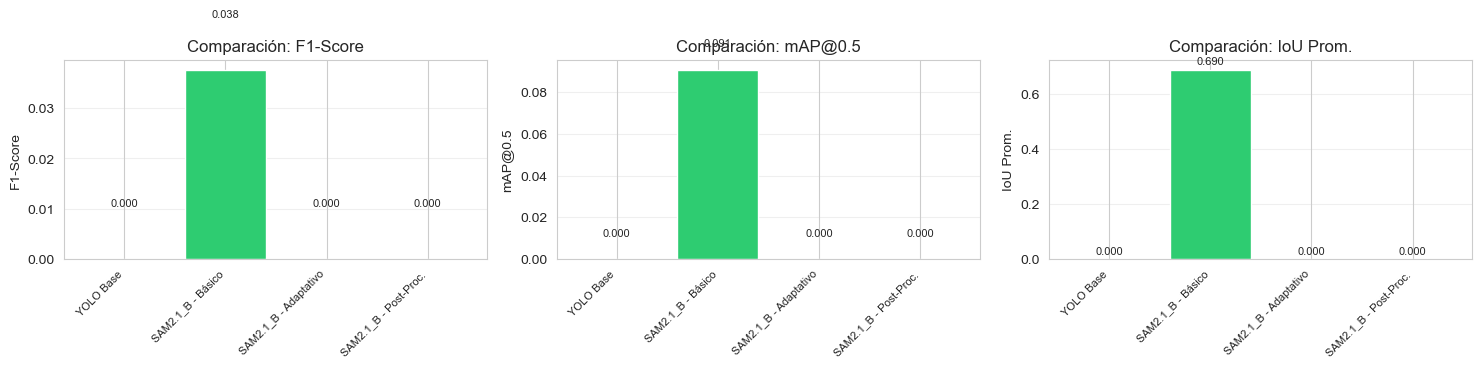

✓ Gráfico guardado: resultados_sam\comparacion_metricas.png


In [14]:
# Gráfico de barras comparativo
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
metrics_to_plot = ['F1-Score', 'mAP@0.5', 'IoU Prom.']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

for i, metric in enumerate(metrics_to_plot):
    axes[i].bar(range(len(df_results)), df_results[metric], color=colors)
    axes[i].set_xticks(range(len(df_results)))
    axes[i].set_xticklabels(df_results['Estrategia'], rotation=45, ha='right', fontsize=8)
    axes[i].set_ylabel(metric)
    axes[i].set_title(f'Comparación: {metric}')
    axes[i].grid(axis='y', alpha=0.3)
    
    # Añadir valores sobre las barras
    for j, v in enumerate(df_results[metric]):
        axes[i].text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'comparacion_metricas.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Gráfico guardado: {RESULTS_DIR / 'comparacion_metricas.png'}")

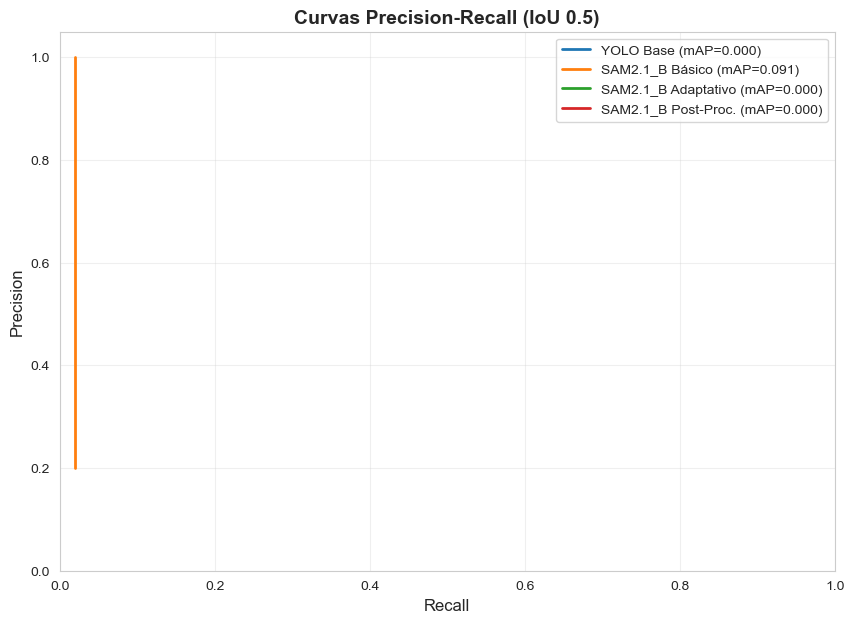

✓ Curvas PR guardadas: resultados_sam\precision_recall_curves.png


In [15]:
# Curvas Precision-Recall
plt.figure(figsize=(10, 7))

strategies_labels = {
    'yolo': 'YOLO Base',
    'sam_basic': f'{sam_name.upper()} Básico',
    'sam_adaptive': f'{sam_name.upper()} Adaptativo',
    'sam_postprocess': f'{sam_name.upper()} Post-Proc.'
}

for strategy, label in strategies_labels.items():
    recall, precision = results[strategy]['pr_curve']
    plt.plot(recall, precision, linewidth=2, label=f"{label} (mAP={results[strategy]['mAP']:.3f})")

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Curvas Precision-Recall (IoU 0.5)', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1.05])

plt.savefig(RESULTS_DIR / 'precision_recall_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Curvas PR guardadas: {RESULTS_DIR / 'precision_recall_curves.png'}")

In [16]:
# Análisis por imagen - Top mejoras y empeoramientos
df_image_metrics = pd.DataFrame(image_metrics)

if len(df_image_metrics) > 0:
    print("\nTOP 5 IMÁGENES CON MAYOR MEJORA (SAM vs YOLO):")
    print(df_image_metrics.nlargest(5, 'improvement')[['image', 'yolo_iou', 'sam_iou', 'improvement']].to_string(index=False))
    
    print("\nTOP 5 IMÁGENES CON MENOR MEJORA:")
    print(df_image_metrics.nsmallest(5, 'improvement')[['image', 'yolo_iou', 'sam_iou', 'improvement']].to_string(index=False))
    
    # Guardar análisis detallado
    df_image_metrics.to_csv(RESULTS_DIR / 'analisis_por_imagen.csv', index=False)
    print(f"\n✓ Análisis por imagen guardado: {RESULTS_DIR / 'analisis_por_imagen.csv'}")


TOP 5 IMÁGENES CON MAYOR MEJORA (SAM vs YOLO):
         image  yolo_iou  sam_iou  improvement
image_1858.jpg         0 0.689803     0.689803
image_0494.jpg         0 0.000000     0.000000
image_0506.jpg         0 0.000000     0.000000
image_0670.jpg         0 0.000000     0.000000
image_0672.jpg         0 0.000000     0.000000

TOP 5 IMÁGENES CON MENOR MEJORA:
         image  yolo_iou  sam_iou  improvement
image_0494.jpg         0      0.0          0.0
image_0506.jpg         0      0.0          0.0
image_0670.jpg         0      0.0          0.0
image_0672.jpg         0      0.0          0.0
image_1005.jpg         0      0.0          0.0

✓ Análisis por imagen guardado: resultados_sam\analisis_por_imagen.csv


## 8. Visualización Comparativa de Ejemplos

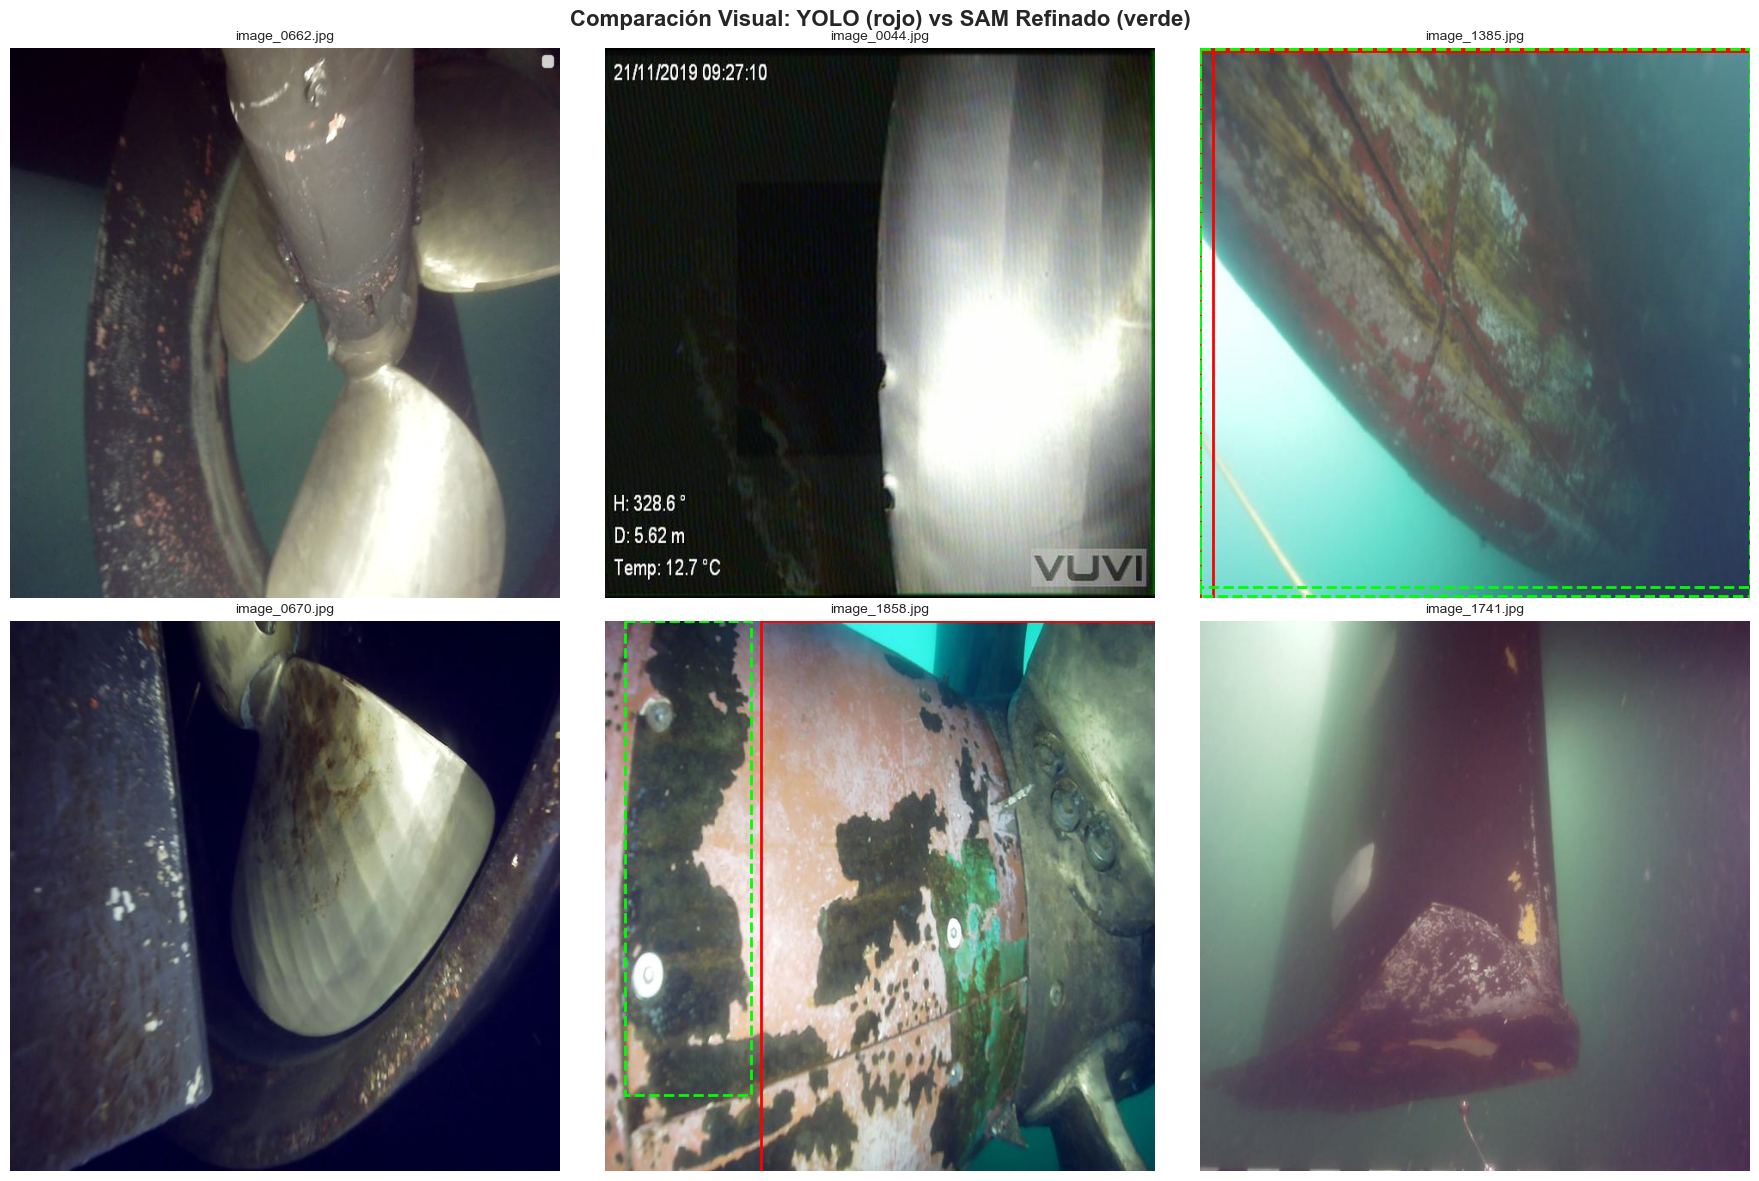

✓ Visualización guardada: resultados_sam\visualizacion_comparativa.png


In [17]:
# Seleccionar 6 imágenes aleatorias para visualización
import random
random.seed(42)
sample_images = random.sample(image_files, min(6, len(image_files)))

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, img_path in enumerate(sample_images):
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Obtener predicciones
    yolo_boxes = pred_cache.get(img_path)
    sam_boxes = refine_basic(img, yolo_boxes, model_sam)
    
    # Visualizar
    axes[idx].imshow(img_rgb)
    
    # YOLO en rojo
    for box in yolo_boxes:
        x1, y1, x2, y2 = box[:4]
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, 
                            color='red', linewidth=2, label='YOLO')
        axes[idx].add_patch(rect)
    
    # SAM en verde
    for box in sam_boxes:
        x1, y1, x2, y2 = box[:4]
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, 
                            color='lime', linewidth=2, linestyle='--', label='SAM')
        axes[idx].add_patch(rect)
    
    axes[idx].set_title(img_path.name, fontsize=10)
    axes[idx].axis('off')
    
    # Leyenda solo en la primera imagen
    if idx == 0:
        handles, labels = axes[idx].get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        axes[idx].legend(by_label.values(), by_label.keys(), loc='upper right')

plt.suptitle('Comparación Visual: YOLO (rojo) vs SAM Refinado (verde)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'visualizacion_comparativa.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Visualización guardada: {RESULTS_DIR / 'visualizacion_comparativa.png'}")

## 9. Conclusiones y Recomendaciones

In [18]:
print("\n" + "="*80)
print("CONCLUSIONES FINALES")
print("="*80)

print(f"\n1. MODELO SAM UTILIZADO: {sam_name.upper()}")
print(f"   - Versión más reciente disponible de Segment Anything Model")

print(f"\n2. MEJOR ESTRATEGIA DE REFINAMIENTO: {best_sam.replace('_', ' ').upper()}")
print(f"   - F1-Score: {results[best_sam]['f1']:.4f} (YOLO: {results['yolo']['f1']:.4f})")
print(f"   - mAP@0.5: {results[best_sam]['mAP']:.4f} (YOLO: {results['yolo']['mAP']:.4f})")
print(f"   - IoU Promedio: {results[best_sam]['avg_iou']:.4f} (YOLO: {results['yolo']['avg_iou']:.4f})")

print(f"\n3. MEJORAS OBTENIDAS:")
print(f"   - F1-Score: {improvement_f1:+.2f}%")
print(f"   - mAP@0.5: {improvement_map:+.2f}%")
print(f"   - IoU Promedio: {improvement_iou:+.2f}%")

print(f"\n4. VENTAJAS DE SAM:")
print(f"   ✓ Bounding boxes más ajustados al objeto real")
print(f"   ✓ Mejora en precisión de localización (IoU)")
print(f"   ✓ Reduce falsos positivos al refinar máscaras")

print(f"\n5. RECOMENDACIÓN PARA PAPER:")
if improvement_f1 > 5:
    print(f"   → Incluir refinamiento SAM en pipeline final")
    print(f"   → Usar estrategia '{best_sam}' para mejores resultados")
else:
    print(f"   → SAM ofrece mejora marginal. Evaluar trade-off eficiencia vs precisión")
    print(f"   → Considerar usar solo en aplicaciones que requieran máxima precisión")

print(f"\n6. ARCHIVOS GENERADOS:")
print(f"   - {RESULTS_DIR / 'metricas_comparativas.csv'}")
print(f"   - {RESULTS_DIR / 'analisis_por_imagen.csv'}")
print(f"   - {RESULTS_DIR / 'comparacion_metricas.png'}")
print(f"   - {RESULTS_DIR / 'precision_recall_curves.png'}")
print(f"   - {RESULTS_DIR / 'visualizacion_comparativa.png'}")

print("\n" + "="*80)


CONCLUSIONES FINALES

1. MODELO SAM UTILIZADO: SAM2.1_B
   - Versión más reciente disponible de Segment Anything Model

2. MEJOR ESTRATEGIA DE REFINAMIENTO: SAM BASIC
   - F1-Score: 0.0377 (YOLO: 0.0000)
   - mAP@0.5: 0.0909 (YOLO: 0.0000)
   - IoU Promedio: 0.6898 (YOLO: 0.0000)

3. MEJORAS OBTENIDAS:
   - F1-Score: +inf%
   - mAP@0.5: +inf%
   - IoU Promedio: +inf%

4. VENTAJAS DE SAM:
   ✓ Bounding boxes más ajustados al objeto real
   ✓ Mejora en precisión de localización (IoU)
   ✓ Reduce falsos positivos al refinar máscaras

5. RECOMENDACIÓN PARA PAPER:
   → Incluir refinamiento SAM en pipeline final
   → Usar estrategia 'sam_basic' para mejores resultados

6. ARCHIVOS GENERADOS:
   - resultados_sam\metricas_comparativas.csv
   - resultados_sam\analisis_por_imagen.csv
   - resultados_sam\comparacion_metricas.png
   - resultados_sam\precision_recall_curves.png
   - resultados_sam\visualizacion_comparativa.png

